# IBL Mesoscopic Data Exploration

Exploring IBL mesoscopic calcium imaging data from:
- **Subject**: SP061
- **Date**: 2025-01-28
- **Session**: 001

Dataset contains: Multiple FOVs, camera data, behavioral data, and neural activity recordings.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define data path and explore structure
data_path = Path(r'D:\IBL-data-share\cortexlab\Subjects\SP061\2025-01-28\001\alf')

if data_path.exists():
    print(f"Data path found: {data_path}")
    
    # List FOV directories
    fov_dirs = sorted([d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('FOV_')])
    print(f"\nFOV directories ({len(fov_dirs)}): {[f.name for f in fov_dirs]}")
    
    # List task directories
    task_dirs = sorted([d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('task_')])
    print(f"Task directories ({len(task_dirs)}): {[t.name for t in task_dirs]}")
    
    # List main files
    main_files = [f for f in data_path.iterdir() if f.is_file()]
    print(f"\nMain files ({len(main_files)}):")
    for f in main_files[:10]:  # Show first 10
        print(f"  {f.name}")
    if len(main_files) > 10:
        print(f"  ... and {len(main_files) - 10} more")
else:
    print(f"Data path not found: {data_path}")

Data path found: D:\IBL-data-share\cortexlab\Subjects\SP061\2025-01-28\001\alf

FOV directories (8): ['FOV_00', 'FOV_01', 'FOV_02', 'FOV_03', 'FOV_04', 'FOV_05', 'FOV_06', 'FOV_07']
Task directories (2): ['task_00', 'task_01']

Main files (11):
  leftCamera.ROIMotionEnergy.npy
  leftROIMotionEnergy.position.npy
  licks.times.npy
  rightCamera.ROIMotionEnergy.npy
  rightROIMotionEnergy.position.npy
  _ibl_leftCamera.dlc.pqt
  _ibl_leftCamera.features.pqt
  _ibl_leftCamera.times.npy
  _ibl_rightCamera.dlc.pqt
  _ibl_rightCamera.features.pqt
  ... and 1 more


## 1. Camera Data


Left Camera:
  Frames: 240066, Duration: 3995.1s
  Frame rate: 60.1 Hz
  Motion - Mean: 5.617, Std: 3.464

Right Camera:
  Frames: 600861, Duration: 3995.1s
  Frame rate: 150.4 Hz
  Motion - Mean: 3.124, Std: 2.119


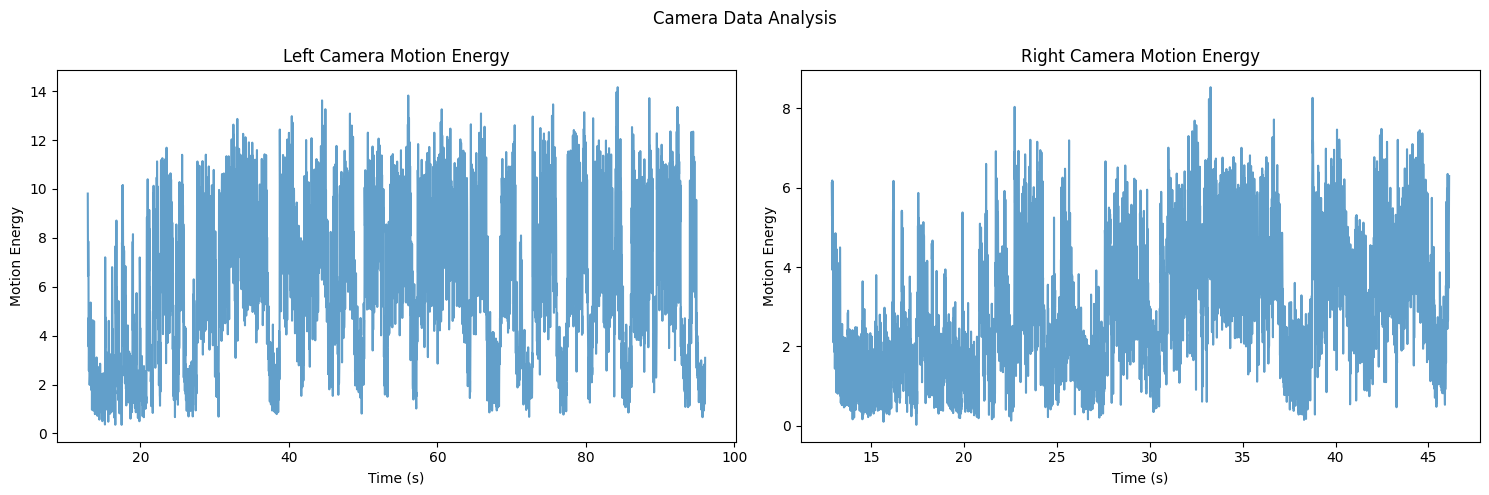

In [3]:
# Load and analyze camera data
camera_data = {}

for camera in ['left', 'right']:
    try:
        # Load camera times
        times_file = data_path / f'_ibl_{camera}Camera.times.npy'
        if times_file.exists():
            camera_data[f'{camera}_times'] = np.load(times_file)
        
        # Load ROI motion energy
        roi_file = data_path / f'{camera}Camera.ROIMotionEnergy.npy'
        if roi_file.exists():
            camera_data[f'{camera}_motion'] = np.load(roi_file)
            
    except Exception as e:
        print(f"Error loading {camera} camera: {e}")

# Plot camera data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Camera Data Analysis')

for i, camera in enumerate(['left', 'right']):
    if f'{camera}_times' in camera_data and f'{camera}_motion' in camera_data:
        times = camera_data[f'{camera}_times']
        motion = camera_data[f'{camera}_motion']
        
        # Plot motion energy (subset for performance)
        n_samples = min(5000, len(times), len(motion))
        axes[i].plot(times[:n_samples], motion[:n_samples], alpha=0.7)
        axes[i].set_title(f'{camera.capitalize()} Camera Motion Energy')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Motion Energy')
        
        # Print stats
        print(f"\n{camera.capitalize()} Camera:")
        print(f"  Frames: {len(times)}, Duration: {times[-1]-times[0]:.1f}s")
        print(f"  Frame rate: {len(times)/(times[-1]-times[0]):.1f} Hz")
        print(f"  Motion - Mean: {np.mean(motion):.3f}, Std: {np.std(motion):.3f}")

plt.tight_layout()
plt.show()

## 2. Behavioral Data

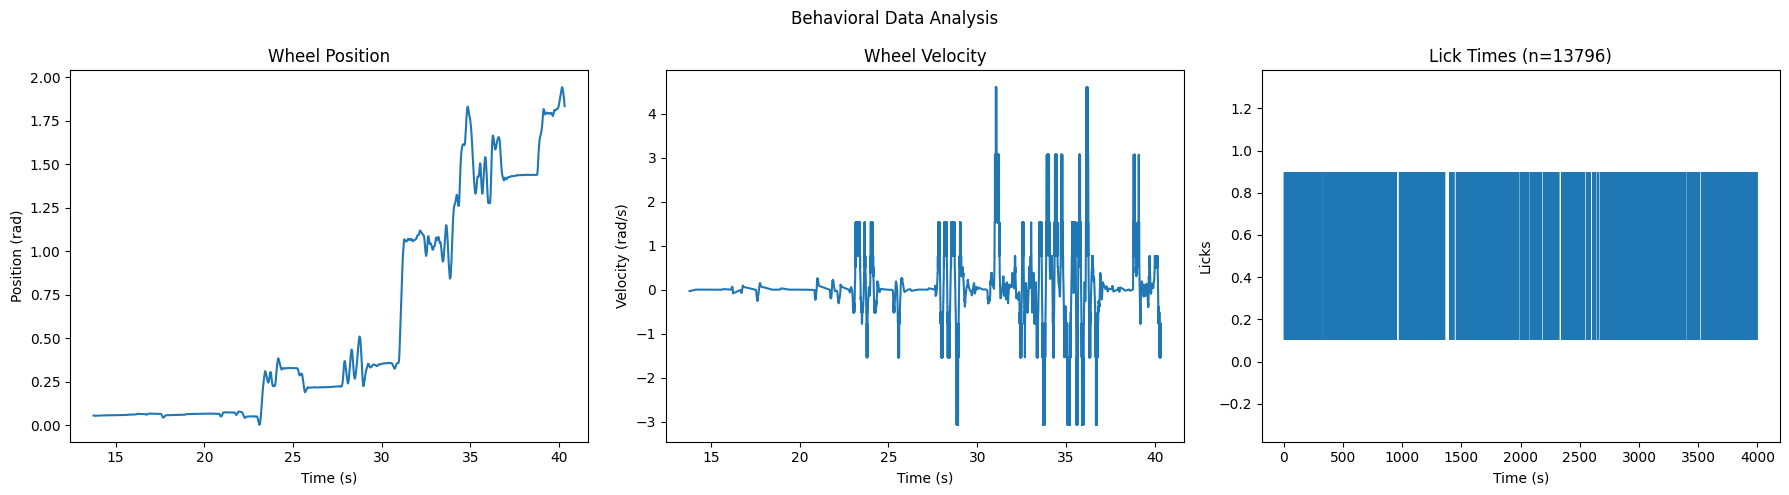


Behavioral Statistics:
Total licks: 13796
Total trials: 522
Trial columns: ['goCue_times', 'response_times', 'choice', 'stimOn_times', 'contrastLeft']...


In [4]:
# Load behavioral data
behavioral_data = {}

# Load licks
licks_file = data_path / 'licks.times.npy'
if licks_file.exists():
    behavioral_data['licks'] = np.load(licks_file)

# Load task data
task_dir = data_path / 'task_00'
if task_dir.exists():
    # Wheel data
    wheel_pos_file = task_dir / '_ibl_wheel.position.npy'
    wheel_times_file = task_dir / '_ibl_wheel.timestamps.npy'
    if wheel_pos_file.exists() and wheel_times_file.exists():
        behavioral_data['wheel_pos'] = np.load(wheel_pos_file)
        behavioral_data['wheel_times'] = np.load(wheel_times_file)
    
    # Trials
    trials_file = task_dir / '_ibl_trials.table.pqt'
    if trials_file.exists():
        behavioral_data['trials'] = pd.read_parquet(trials_file)

# Plot behavioral data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Behavioral Data Analysis')

# Wheel position
if 'wheel_pos' in behavioral_data:
    pos = behavioral_data['wheel_pos']
    times = behavioral_data['wheel_times']
    n_samples = min(5000, len(pos))
    axes[0].plot(times[:n_samples], pos[:n_samples])
    axes[0].set_title('Wheel Position')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Position (rad)')

# Wheel velocity
if 'wheel_pos' in behavioral_data:
    velocity = np.diff(pos) / np.diff(times)
    n_samples = min(5000, len(velocity))
    axes[1].plot(times[1:n_samples+1], velocity[:n_samples])
    axes[1].set_title('Wheel Velocity')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Velocity (rad/s)')

# Licks
if 'licks' in behavioral_data:
    licks = behavioral_data['licks']
    axes[2].eventplot([licks], lineoffsets=0.5, linelengths=0.8)
    axes[2].set_title(f'Lick Times (n={len(licks)})')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Licks')

plt.tight_layout()
plt.show()

# Print behavioral stats
print("\nBehavioral Statistics:")
if 'licks' in behavioral_data:
    print(f"Total licks: {len(behavioral_data['licks'])}")
if 'trials' in behavioral_data:
    trials = behavioral_data['trials']
    print(f"Total trials: {len(trials)}")
    print(f"Trial columns: {list(trials.columns)[:5]}...")  # Show first 5 columns

## 3. Neural Activity (FOV_00 Example)

Error loading neural data: The file D:\IBL-data-share\cortexlab\Subjects\SP061\2025-01-28\001\alf\FOV_00\mpciROIs.masks.sparse_npz does not contain a sparse array or matrix.


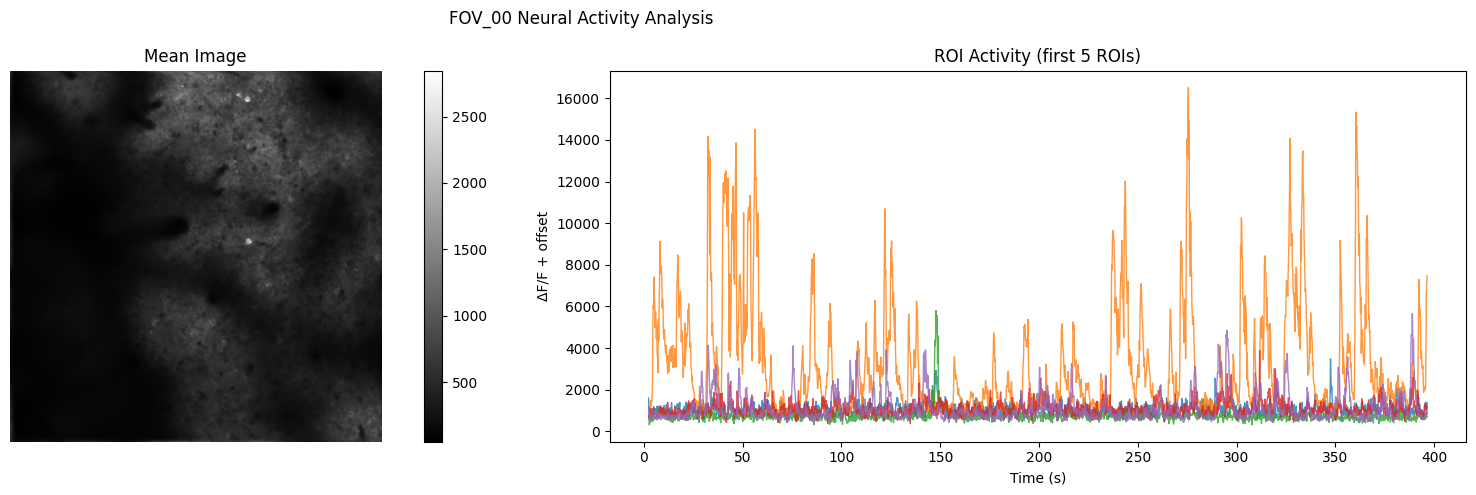


Neural Data Statistics (FOV_00):
Activity shape: (19569, 2228)
Number of ROIs: 2228
Recording duration: 3877.9s


In [7]:
# Load neural data from FOV_00
fov_path = data_path / 'FOV_00'
neural_data = {}

if fov_path.exists():
    try:
        # Load timing
        times_file = fov_path / 'mpci.times.npy'
        if times_file.exists():
            neural_data['times'] = np.load(times_file)
        
        # Load ROI activity
        activity_file = fov_path / 'mpci.ROIActivityF.npy'
        if activity_file.exists():
            neural_data['activity'] = np.load(activity_file)
        
        # Load mean image
        img_file = fov_path / 'mpciMeanImage.images.npy'
        if img_file.exists():
            neural_data['mean_image'] = np.load(img_file)
        
        # Load ROI masks
        masks_file = fov_path / 'mpciROIs.masks.sparse_npz'
        if masks_file.exists():
            neural_data['masks'] = sp.load_npz(masks_file)
            
    except Exception as e:
        print(f"Error loading neural data: {e}")

# Plot neural data
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('FOV_00 Neural Activity Analysis')

# Mean image
if 'mean_image' in neural_data:
    img = neural_data['mean_image']
    if img.ndim == 3:
        img = np.mean(img, axis=0) if img.shape[0] < 10 else img[0]
    im1 = axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Mean Image')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0])

# ROI activity traces
if 'activity' in neural_data and 'times' in neural_data:
    activity = neural_data['activity']
    times = neural_data['times']
    
    if activity.ndim == 2:
        # Plot first 5 ROIs
        n_rois = min(5, activity.shape[1])
        n_time = min(2000, len(times), activity.shape[0])
        
        for i in range(n_rois):
            axes[1].plot(times[:n_time], activity[:n_time, i] + i*2, 
                        alpha=0.8, linewidth=1)
        axes[1].set_title(f'ROI Activity (first {n_rois} ROIs)')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('ΔF/F + offset')

plt.tight_layout()
plt.show()

# Print neural stats
print("\nNeural Data Statistics (FOV_00):")
if 'activity' in neural_data:
    activity = neural_data['activity']
    print(f"Activity shape: {activity.shape}")
    print(f"Number of ROIs: {activity.shape[1] if activity.ndim > 1 else 'N/A'}")
    print(f"Recording duration: {neural_data['times'][-1] - neural_data['times'][0]:.1f}s")
if 'masks' in neural_data:
    masks = neural_data['masks']
    print(f"ROI masks: {masks.shape} sparse matrix with {masks.nnz} non-zero elements")

In [10]:
neural_data.keys()

dict_keys(['times', 'activity', 'mean_image'])

## 4. Multi-FOV Summary


Multi-FOV Summary:
   FOV  n_ROIs  n_timepoints  duration_s  sampling_rate_hz
FOV_00    2228         19569    3877.899          5.046289
FOV_01     916         19569    3877.899          5.046289
FOV_02    3999         19569    3877.899          5.046289
FOV_03    4019         19569    3877.899          5.046289
FOV_04    4413         19569    3877.899          5.046289
FOV_05    2894         19569    3877.899          5.046289
FOV_06    4104         19569    3877.899          5.046289
FOV_07    3035         19569    3877.899          5.046289


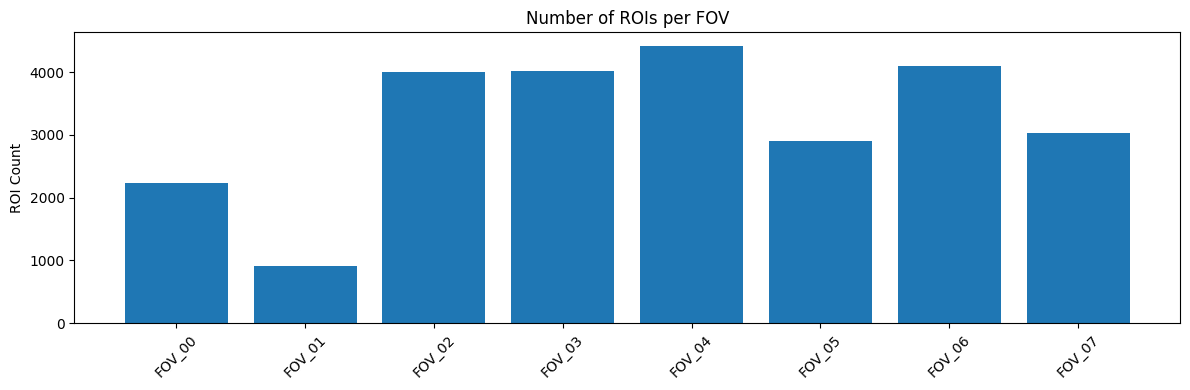


Total ROIs across all FOVs: 25608
Average sampling rate: 5.0 Hz


In [8]:
# Quick summary across all FOVs
fov_summary = []

for fov_dir in fov_dirs:
    try:
        # Check for key files
        activity_file = fov_dir / 'mpci.ROIActivityF.npy'
        times_file = fov_dir / 'mpci.times.npy'
        
        if activity_file.exists() and times_file.exists():
            activity = np.load(activity_file)
            times = np.load(times_file)
            
            fov_summary.append({
                'FOV': fov_dir.name,
                'n_ROIs': activity.shape[1] if activity.ndim > 1 else 0,
                'n_timepoints': len(times),
                'duration_s': times[-1] - times[0] if len(times) > 1 else 0,
                'sampling_rate_hz': len(times) / (times[-1] - times[0]) if len(times) > 1 else 0
            })
    except Exception as e:
        print(f"Error processing {fov_dir.name}: {e}")

# Display summary
if fov_summary:
    summary_df = pd.DataFrame(fov_summary)
    print("\nMulti-FOV Summary:")
    print(summary_df.to_string(index=False))
    
    # Plot summary
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    
    axes.bar(summary_df['FOV'], summary_df['n_ROIs'])
    axes.set_title('Number of ROIs per FOV')
    axes.set_ylabel('ROI Count')
    axes.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal ROIs across all FOVs: {summary_df['n_ROIs'].sum()}")
    print(f"Average sampling rate: {summary_df['sampling_rate_hz'].mean():.1f} Hz")
else:
    print("No FOV data found or accessible.")

In [5]:
import json
metadata_raw_imaging_filepath = (
    r"D:\IBL-data-share\cortexlab\Subjects\SP061\2025-01-28\001\raw_imaging_data_00\_ibl_rawImagingData.meta.json"
)
# load metadata_raw_imaging_filepath as dict and print keys
with open(metadata_raw_imaging_filepath, 'r') as f:
    metadata_content = json.load(f)
    for key, value in metadata_content.items():
        print(key, value)

version 0.2.0
channelID {'green': [1, 2], 'red': [3, 4], 'primary': [2, 4], 'secondary': [1, 3]}
laserPowerCalibration {'V': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3, 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45, 4.5, 4.55, 4.6, 4.65, 4.7, 4.75, 4.8, 4.85, 4.9, 4.95, 5], 'Prcnt': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82

In [2]:
# load the following npy file:
import numpy as np
ScanImage_times_filepath = (r"D:\IBL-data-share\cortexlab\Subjects\SP061\2025-01-28\001\raw_imaging_data_00\rawImagingData.times_scanImage.npy")
ScanImage_times = np.load(ScanImage_times_filepath)
print(ScanImage_times)

[[0.00000000e+00]
 [1.97132150e-01]
 [3.94264320e-01]
 ...
 [3.22072509e+03]
 [3.22092227e+03]
 [3.22111944e+03]]


In [3]:
ScanImage_times.shape

(16338, 1)

## Summary

This notebook provides a comprehensive exploration of the IBL mesoscopic dataset including:

1. **Camera Data**: Frame timing and motion energy analysis
2. **Behavioral Data**: Wheel movements, licks, and trial information
3. **Neural Activity**: ROI-based calcium imaging data from multiple FOVs
4. **Multi-FOV Analysis**: Summary statistics across all field of views

The dataset contains rich multimodal data suitable for studying brain-behavior relationships during task performance.